# Task:
Implement for a useful nontrivial use case of your choice the EM Algorithm
(e.g., three coins, two dice, two Gaussians, two different non-Gaussians),
surrogate data creation included. Nice documentation, commenting, presentations, take homes and animations are welcome.

## about EM Algorithm (Expectation-maximization algorithm)

The Expectation-Maximization (EM) algorithm is a method used in statistics to estimate the parameters of complex probability models. This algorithm is particularly suitable for situations where model parameters are not easily observed or calculated directly. We can think of it as a "guess-and-check" process used to progressively approximate the correct model parameters.



### Simple Explanation:

Imagine you are a detective trying to uncover the truth about an incident, but you only have incomplete clues. The EM algorithm is like initially making a preliminary guess based on the available clues (the Expectation step), then searching for more evidence to see if this guess makes sense (the Maximization step). By continuously guessing and verifying, you gradually get closer to the truth of the incident.

### Specific Steps:

1. **Expectation Step (E-step)**: Based on the current estimate of parameters, calculate or "guess" the values of hidden variables. This is like speculating possible scenarios based on the existing clues.

2. **Maximization Step (M-step)**: Update the estimation of parameters to make the model more "reasonable" for the observed data. This is similar to adjusting your clues and hypotheses based on new speculations to make the explanation of the case more reasonable.

### Example:

Imagine a classroom with two types of candies, apple-flavored and orange-flavored, stored in two different jars. We do not know how many of each flavor are in each jar, but we can randomly sample some candies from each jar to taste.

- **E-step**: Based on the current estimate (for example, initially guessing that each jar contains half apple and half orange), we try to estimate the probability of drawing each flavor from each jar.
- **M-step**: According to the data of candies tasted, adjust our estimates of the distribution of candies in the jars, for instance, finding that one jar might contain more apple-flavored candies.

By repeatedly performing these two steps, we can gradually obtain estimates of the proportion of candy flavors in each jar, even though we initially did not know the exact distribution.

In [2]:
# Generate surrogate data
import random

# Number of experiments
experiments = 10 #the smaller this number the worse the performance/estimate

# Number of coin tosses for each trial
coin_tosses = 25 #the smaller this number the worse the performance/estimate

# Experiment ground truth properties: Prob to choose coin A for the trial
pA = 0.5
pB = 1-pA
# Coin ground truth properties: Prob for heads and tails
p_heads_A = 0.7
p_heads_B = 0.5

# empty array where all tosses are stored
rolls= []

A_heads = 0
B_heads = 0
A_tails = 0
B_tails = 0

for i in range(0,experiments):
    trial = ""
    A=0
    # Choose coin: p fixed for single trial
    if ( random.uniform(0, 1) < pA ): 
        p = p_heads_A
        A=1
    else:
        p = p_heads_B
        A=0
        
    for j in range(0,coin_tosses):
        # generate outcome
        outcome = random.uniform(0, 1)
        if (outcome < p): 
            trial += "H"
            if (A==1): 
                A_heads += 1
            else:
                B_heads += 1
        else: 
            trial += "T"
            if (A==1): 
                A_tails += 1
            else:
                B_tails += 1
    rolls.append( trial ) 
    
#print entire outcomes of experiment     
print(rolls)
print(A_heads,B_heads)
print(A_tails,B_tails)

['THTTTTHTTHTHTTHTTHTHTTHTT', 'HTTHHHHHHTHHHHHHHHHHHTHHT', 'THHTHHHTHHTTHTTHTHTTHHTHT', 'HHHHTTTTHTHHHTTHHTTHHHHHT', 'THHHHHTHHHHHHHHHTHTHHHHHH', 'THTHTTHTTTHTHHHTTTHTHTTTH', 'HTHHHHHHHHHHHTTHHHTHTTHHH', 'HHHTHHTHHHTHHHTHHHHTTHHHT', 'HHHHTHTTTTTHHTTHTHHTHHHHT', 'TTTHHHTTHHTTTTTHTHTTHTTTT']
78 68
22 82


In [5]:
import random

# Number of experiments
experiments = 10

# Number of dice rolls for each trial
dice_rolls = 25

# Experiment ground truth properties: Prob to choose Dice A for the trial
pA = 0.5
pB = 1-pA

# Dice types
# Dice A: Normal 6-sided dice
# Dice B: Special dice with only 1 and 6 outcomes, each with 50% probability

# Empty array where all rolls are stored
rolls= []

A_results = [0]*6  # Count of outcomes for Dice A (1-6)
B_results = [0]*2  # Count of outcomes for Dice B (only two possible outcomes, stored as [count1, count6])

for i in range(0,experiments):
    trial = []
    # Choose dice: p fixed for single trial
    if random.uniform(0, 1) < pA:
        dice_type = "A"
    else:
        dice_type = "B"
        
    for j in range(0,dice_rolls):
        # Generate outcome
        if dice_type == "A":
            outcome = random.randint(1, 6)
            A_results[outcome-1] += 1
        else:
            outcome = random.choice([1, 6])
            if outcome == 1:
                B_results[0] += 1
            else:
                B_results[1] += 1
        trial.append(outcome)
    rolls.append(trial)

# Convert results of Dice B to show [count1, count6] instead of [1, 6] outcomes
B_results_converted = {'1': B_results[0], '6': B_results[1]}

rolls, A_results, B_results_converted


([[4, 1, 6, 3, 3, 4, 6, 2, 5, 4, 2, 5, 3, 4, 3, 1, 5, 1, 4, 3, 2, 4, 6, 2, 1],
  [1, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 1, 6, 6, 6, 1, 1, 6, 1],
  [6, 1, 6, 6, 6, 1, 6, 6, 6, 1, 1, 6, 1, 1, 6, 1, 6, 6, 6, 6, 1, 6, 1, 6, 1],
  [5, 4, 2, 6, 3, 5, 2, 2, 5, 3, 4, 6, 3, 3, 1, 4, 3, 4, 4, 5, 5, 6, 1, 1, 5],
  [6, 1, 6, 1, 6, 6, 6, 6, 1, 6, 6, 1, 1, 6, 1, 6, 6, 6, 1, 6, 1, 6, 6, 1, 1],
  [1, 1, 6, 4, 1, 5, 6, 3, 3, 6, 3, 3, 2, 2, 3, 1, 4, 2, 2, 6, 3, 4, 3, 6, 2],
  [1, 6, 3, 2, 5, 4, 3, 6, 3, 1, 6, 2, 6, 2, 6, 5, 3, 2, 6, 1, 5, 2, 3, 6, 3],
  [5, 2, 3, 1, 5, 3, 5, 5, 3, 4, 6, 2, 5, 2, 1, 1, 4, 2, 3, 3, 6, 5, 6, 6, 4],
  [6, 4, 1, 4, 4, 6, 3, 1, 1, 2, 2, 2, 6, 4, 2, 6, 4, 6, 3, 2, 6, 4, 3, 2, 4],
  [6, 2, 6, 6, 6, 1, 5, 3, 4, 5, 1, 4, 6, 2, 5, 5, 2, 1, 1, 6, 2, 6, 2, 6, 4]],
 [24, 32, 32, 28, 23, 36],
 {'1': 34, '6': 41})

In [24]:
import random

def generate_dice_data(experiments, dice_rolls):
    # 定义两种骰子的结果概率
    # Dice A: 正常六面骰，每面等概率
    # Dice B: 特殊骰子，只出现1和6，各50%概率
    results = []

    for _ in range(experiments):
        trial = []
        if random.random() < 0.5:  # 选择骰子A或骰子B
            probabilities = [1/6] * 6  # 骰子A的概率分布
        else:
            probabilities = [0.5, 0] * 3  # 骰子B的概率分布（1和6各占50%）

        for _ in range(dice_rolls):
            outcome = random.choices(range(1, 7), weights=probabilities)[0]
            trial.append(outcome)
        results.append(trial)
    
    return results

# 测试生成的数据
generate_dice_data(10, 10)


[[6, 4, 6, 3, 4, 3, 1, 1, 3, 6],
 [6, 1, 3, 2, 3, 3, 5, 1, 6, 5],
 [5, 1, 1, 5, 5, 3, 5, 1, 3, 1],
 [5, 3, 2, 2, 2, 2, 2, 4, 4, 3],
 [1, 5, 5, 1, 5, 3, 1, 5, 5, 3],
 [6, 3, 4, 4, 4, 2, 6, 2, 1, 6],
 [1, 5, 5, 3, 3, 5, 1, 3, 3, 5],
 [1, 2, 1, 2, 1, 5, 5, 2, 4, 3],
 [5, 5, 1, 1, 5, 1, 5, 1, 5, 5],
 [2, 5, 4, 4, 5, 1, 6, 3, 3, 3]]

In [25]:
import numpy as np
import random

def em_algorithm(data, max_iter=50):
    # 骰子A有6种结果，骰子B只关注两种结果（1和6）
    theta_A = np.array([1/6] * 6)
    theta_B = np.array([0.5,0,0,0,0, 0.5])  # 只关心1和6的概率

    # 迭代执行EM算法
    for _ in range(max_iter):
        # 初始化计数器
        counts_A = np.zeros(6)
        counts_B = np.zeros(2)

        # E步骤：根据当前参数估计计算每个结果的概率贡献
        for trial in data:
            trial_counts_A = np.zeros(6)
            trial_counts_B = np.zeros(2)

            for outcome in trial:
                if outcome in [1, 6]:  # 如果结果可能由骰子B生成
                    # 计算属于骰子A和骰子B的概率
                    prob_A = theta_A[outcome - 1]
                    prob_B = theta_B[0] if outcome == 1 else theta_B[1]

                    # 归一化这些概率
                    total_prob = prob_A + prob_B
                    prob_A /= total_prob
                    prob_B /= total_prob

                    # 分配计数
                    trial_counts_A[outcome - 1] += prob_A
                    if outcome == 1:
                        trial_counts_B[0] += prob_B
                    else:
                        trial_counts_B[1] += prob_B
                else:  # 只可能由骰子A生成
                    trial_counts_A[outcome - 1] += 1

            # 累加到全局计数
            counts_A += trial_counts_A
            counts_B += trial_counts_B

        # M步骤：更新参数估计
        total_A = counts_A.sum()
        if total_A > 0:
            theta_A = counts_A / total_A

        total_B = counts_B.sum()
        if total_B > 0:
            theta_B = counts_B / total_B

    return theta_A, theta_B

# 初始化数据
data = generate_dice_data(200, 25)
# 运行EM算法
final_theta_A, final_theta_B = em_algorithm(data)

# 打印结果
print("Final probabilities for Dice A:", final_theta_A)
print("Final probabilities for Dice B (only for outcomes 1 and 6):", final_theta_B)


Final probabilities for Dice A: [1.72681730e-25 1.14126097e-01 3.32535249e-01 1.11465815e-01
 3.35727587e-01 1.06145251e-01]
Final probabilities for Dice B (only for outcomes 1 and 6): [1. 0.]


In [26]:
import numpy as np
import random

def generate_dice_data(experiments, dice_rolls):
    # 定义两种骰子的结果概率
    # Dice A: 正常六面骰，每面等概率
    # Dice B: 特殊骰子，只出现1和6，各50%概率
    results = []
    dice_types = []

    for _ in range(experiments):
        trial = []
        if random.random() < 0.5:  # 选择骰子A或骰子B
            dice_type = 'A'
            probabilities = [1/6] * 6  # 骰子A的概率分布
        else:
            dice_type = 'B'
            probabilities = [0.5, 0, 0, 0, 0, 0.5]  # 骰子B的概率分布

        for _ in range(dice_rolls):
            outcome = random.choices(range(1, 7), weights=probabilities)[0]
            trial.append(outcome)
        results.append((dice_type, trial))
        dice_types.append(dice_type)
    
    return results, dice_types

def em_algorithm(data, max_iter=50):
    # 骰子A有6种结果，骰子B只关注两种结果（1和6）
    theta_A = np.array([1/6] * 6)
    theta_B = np.array([0.5, 0.5])  # 只关心1和6的概率

    # 迭代执行EM算法
    for _ in range(max_iter):
        # 初始化计数器
        counts_A = np.zeros(6)
        counts_B = np.zeros(2)

        # E步骤：根据当前参数估计计算每个结果的概率贡献
        for dice_type, trial in data:
            trial_counts_A = np.zeros(6)
            trial_counts_B = np.zeros(2)

            for outcome in trial:
                if outcome in [1, 6]:  # 如果结果可能由骰子B生成
                    # 计算属于骰子A和骰子B的概率
                    prob_A = theta_A[outcome - 1]
                    prob_B = theta_B[0] if outcome == 1 else theta_B[1]

                    # 归一化这些概率
                    total_prob = prob_A + prob_B
                    prob_A /= total_prob
                    prob_B /= total_prob

                    # 分配计数
                    trial_counts_A[outcome - 1] += prob_A
                    if outcome == 1:
                        trial_counts_B[0] += prob_B
                    else:
                        trial_counts_B[1] += prob_B
                else:  # 只可能由骰子A生成
                    trial_counts_A[outcome - 1] += 1

            # 累加到全局计数
            counts_A += trial_counts_A
            counts_B += trial_counts_B

        # M步骤：更新参数估计
        total_A = counts_A.sum()
        if total_A > 0:
            theta_A = counts_A / total_A

        total_B = counts_B.sum()
        if total_B > 0:
            theta_B = counts_B / total_B

    return theta_A, theta_B

# 初始化数据
data, dice_types = generate_dice_data(100, 1000)  # 生成较多的数据以提高估计的准确性
final_theta_A, final_theta_B = em_algorithm(data)

# 打印结果
final_theta_A, final_theta_B


(array([0.10044197, 0.19914   , 0.1967    , 0.20058   , 0.20336   ,
        0.09977803]),
 array([0.50165803, 0.49834197]))

In [29]:
def generate_dice_data(experiments, dice_rolls, prob_B):
    # Dice A: 正常六面骰，每面等概率
    # Dice B: 根据提供的prob_B数组决定概率分布
    results = []
    dice_types = []

    for _ in range(experiments):
        trial = []
        if random.random() < 0.5:  # 随机选择骰子A或骰子B
            dice_type = 'A'
            probabilities = [1/6] * 6  # 骰子A的概率分布
        else:
            dice_type = 'B'
            probabilities = prob_B  # 骰子B的自定义概率分布

        for _ in range(dice_rolls):
            outcome = random.choices(range(1, 7), weights=probabilities)[0]
            trial.append(outcome)
        results.append((dice_type, trial))
        dice_types.append(dice_type)
    
    return results, dice_types


In [89]:
def em_algorithm_tracking(data, max_iter=50):
    theta_A = np.random.rand(6)
    theta_B = np.random.rand(6)  # 初始化骰子B概率为0，稍后根据实际情况调整

    theta_A_history = []
    theta_B_history = []
    
    theta_A_history.append(theta_A.copy())
    theta_B_history.append(theta_B.copy())

    for _ in range(max_iter):
        counts_A = np.zeros(6)
        counts_B = np.zeros(6)

        for dice_type, trial in data:
            trial_counts_A = np.zeros(6)
            trial_counts_B = np.zeros(6)

            for outcome in trial:
                prob_A = theta_A[outcome - 1]
                prob_B = theta_B[outcome - 1]

                total_prob = prob_A + prob_B if dice_type == 'B' else prob_A
                prob_A /= total_prob
                prob_B /= total_prob

                trial_counts_A[outcome - 1] += prob_A
                if dice_type == 'B':
                    trial_counts_B[outcome - 1] += prob_B

            counts_A += trial_counts_A
            counts_B += trial_counts_B

        total_A = counts_A.sum()
        if total_A > 0:
            theta_A = counts_A / total_A

        total_B = counts_B.sum()
        if total_B > 0:
            theta_B = counts_B / total_B

        theta_A_history.append(theta_A.copy())
        theta_B_history.append(theta_B.copy())

    return theta_A, theta_B, theta_A_history, theta_B_history


[0.17670498 0.17839324 0.18017938 0.17932301 0.10585618 0.17954322] [0.44900514 0.13782731 0.14135154 0.136424   0.         0.13539202]


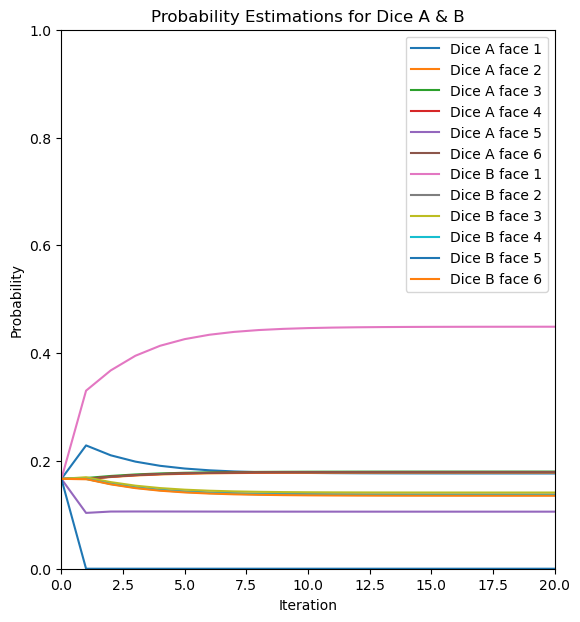

In [80]:
# 初始化数据
data, dice_types = generate_dice_data(100, 1000,[2/6,1/6,1/6,1/6,0,1/6])  # 生成较多的数据以提高估计的准确性
final_theta_A, final_theta_B, theta_A_history, theta_B_history = em_algorithm_tracking(data, 100)

print(final_theta_A, final_theta_B)

# 可视化迭代过程
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
for i in range(6):
    plt.plot([theta[i] for theta in theta_A_history], label=f'Dice A face {i+1}')
for i in range(6):
    plt.plot([theta[i] for theta in theta_B_history], label=f'Dice B face {i+1}')

plt.ylim(0,1)
plt.xlim(0,20)
plt.title('Probability Estimations for Dice A & B')
plt.xlabel('Iteration')
plt.ylabel('Probability')
plt.legend()

plt.show()


In [81]:
import matplotlib.pyplot as plt

def plot_dice_likelihood(rolls, theta_A_history, theta_B_history):
    # 设置图表大小
    plt.figure(figsize=(12, 6))

    # 绘制骰子A的概率变化
    plt.subplot(1, 2, 1)
    for i in range(6):
        plt.plot([theta[i] for theta in theta_A_history], label=f'Face {i+1}')
    plt.ylim(0,1)
    plt.title('Probability Estimations for Dice A Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Probability')
    plt.legend()

    # 绘制骰子B的概率变化
    plt.subplot(1, 2, 2)
    for i in range(6):
        plt.plot([theta[i] for theta in theta_B_history], label=f'Face {i+1}')
    plt.ylim(0,1)
    plt.title('Probability Estimations for Dice B Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Probability')
    plt.legend()

    plt.tight_layout()
    plt.show()


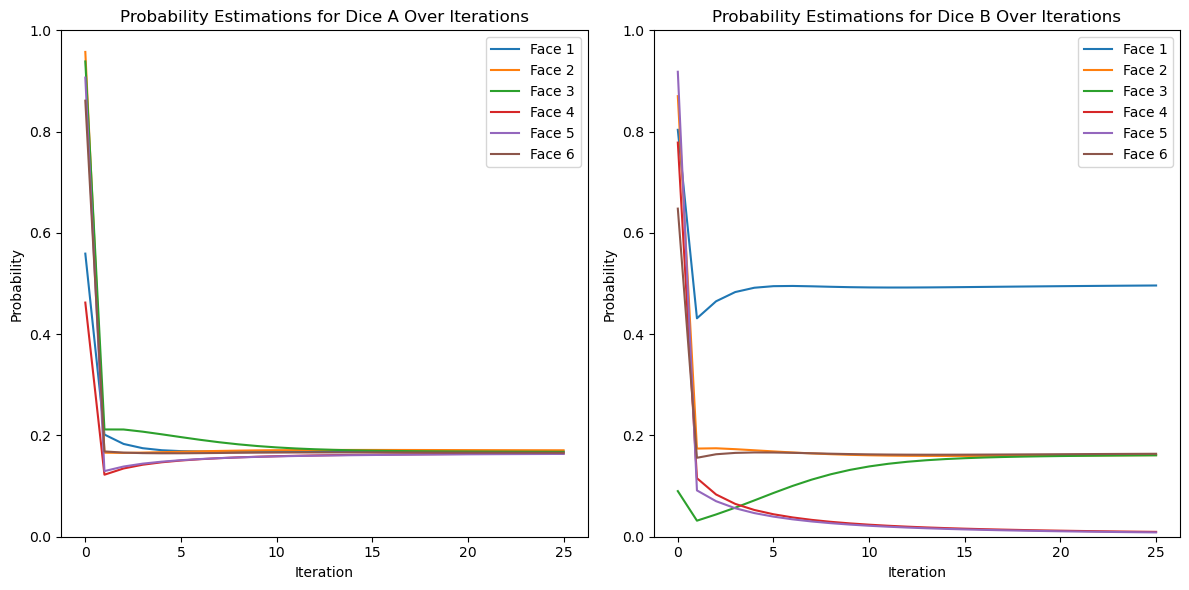

[0.16806029 0.17070723 0.1676618  0.16428104 0.16351469 0.16577495] [0.49612115 0.16117047 0.16080599 0.00958007 0.00851684 0.16380547]


In [91]:
data, dice_types = generate_dice_data(100, 1000,[2/6,1/6,1/6,1/12,1/12,1/6])
final_theta_A, final_theta_B, theta_A_history, theta_B_history = em_algorithm_tracking(data, 25)
plot_dice_likelihood(data, theta_A_history, theta_B_history)
print(final_theta_A, final_theta_B)

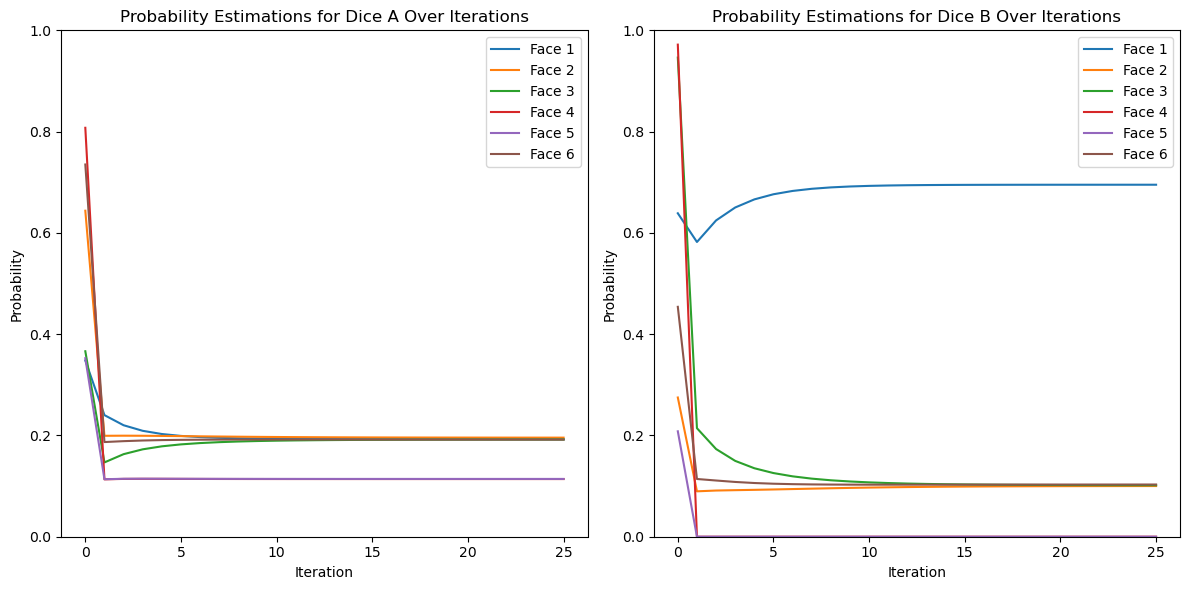

[0.19268485 0.19565733 0.19191379 0.11388866 0.11412736 0.191728  ] [0.69511193 0.10008377 0.10170324 0.         0.         0.10310107]


In [92]:
data, dice_types = generate_dice_data(100, 1000,[3/6, 1/6, 1/6 ,0, 0, 1/6])
final_theta_A, final_theta_B, theta_A_history, theta_B_history = em_algorithm_tracking(data, 25)
plot_dice_likelihood(data, theta_A_history, theta_B_history)
print()
print(final_theta_A, final_theta_B)

In [ ]:
 np.random.rand(6)

array([0.46658797, 0.36023049, 0.99450633, 0.41077442, 0.62119644,
       0.58334104])